# Home Credit EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr, randint, uniform
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from IPython.display import display
import warnings
import pickle
import gc

%load_ext autotime

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
gc.enable()
np.random.seed(123)

path = "/Users/dsaxton/home_credit_default/"

In [40]:
def get_interactions(df, cols, kinds=["prod"]):
    if len(set(kinds).difference(set(["prod", "div", "diff", "sum"]))) > 0:
        raise ValueError("Allowable kinds: prod, div, diff, sum.")
    frame = pd.DataFrame()
    for i, c1 in enumerate(cols):
        for c2 in cols[i+1:]:
            for kind in kinds:
                frame[c1 + "__" + kind + "__" + c2] = {"prod": df[c1] * df[c2], 
                                                      "div": df[c1] / df[c2], 
                                                      "diff": df[c1] - df[c2], 
                                                      "sum": df[c1] + df[c2]}[kind]
    return frame

time: 12.9 ms


In [3]:
impute = Imputer(strategy="median")
scale = StandardScaler()

time: 1.11 ms


In [28]:
train = pd.read_csv(path + "train.csv")

time: 53.4 s


In [41]:
application = pd.read_csv(path + "application_train.csv")

time: 18.9 s


In [41]:
previous_application = pd.read_csv(path + "previous_application.csv")

time: 18.9 s


In [103]:
bureau_balance = pd.read_csv(path + "bureau_balance.csv")

time: 13.9 s


In [104]:
bureau = pd.read_csv(path + "bureau.csv")

time: 7.57 s


In [95]:
credit_card = pd.read_csv(path + "credit_card_balance.csv")

time: 31.8 s


In [81]:
pos_cash = pd.read_csv(path + "POS_CASH_balance.csv")

time: 18 s


In [5]:
pos_cash_agg = pd.read_csv(path + "pos_cash_agg.csv")

time: 467 ms


In [7]:
previous_agg = pd.read_csv(path + "previous_agg.csv")

time: 19.4 s


In [9]:
credit_card_agg = pd.read_csv(path + "credit_card_agg.csv")

time: 2.74 s


In [11]:
installment_agg = pd.read_csv(path + "installment_agg.csv")

time: 4.87 s


In [38]:
bureau_agg = pd.read_csv(path + "bureau_agg.csv")

time: 12.8 s


In [44]:
train = pd.read_csv(path + "train.csv")

time: 12.2 s


In [45]:
bureau_agg.head()

,SK_ID_CURR,SUM_AMT_CREDIT_SUM_DEBT_DIV_DAYS_CREDIT_ENDDATE_ACTIVE_12M,SUM_CC_DEBT_6M,SUM_CC_DEBT_12M,MAX_WORST_DQ_BUREAU_BALANCE_6M,MAX_WORST_DQ_BUREAU_BALANCE_12M,MAX_BUREAU_UTILIZATION_6M,MAX_BUREAU_UTILIZATION_12M,COUNT_ACTIVE_6M,COUNT_ACTIVE_12M,COUNT_ACTIVE_24M,DAYS_REMAINING_ACTIVE,MAX_CREDIT_DAY_OVERDUE_6M,MAX_CREDIT_DAY_OVERDUE_DIFF_6M_12M,BUREAU_UTILIZATION_DIFF_6M_12M,BUREAU_UTILIZATION_DIFF_12M_24M,BUREAU_SUM_DEBT_DIFF_6M_12M,BUREAU_SUM_DEBT_DIFF_12M_24M,MAX_CNT_CREDIT_PROLONG,AVG_LEN_BUREAU_BALANCE,PROP_CURRENT,PROP_CLOSED,PROP_CURRENT_WEIGHTED,MAX_AVG_MONTHS_BALANCE_BUREAU_BALANCE,MIN_AVG_MONTHS_BALANCE_BUREAU_BALANCE,RANGE_AVG_MONTHS_BALANCE_BUREAU_BALANCE,SUM_SUM_CURRENT_BUREAU_BALANCE,AVG_PROP_CURRENT,AVG_PROP_DQ,MAX_PROP_DQ,AVG_PROP_CURRENT_WEIGHTED,MIN_PROP_CURRENT_WEIGHTED,AVG_PROP_DQ_WEIGHTED,MAX_PROP_DQ_WEIGHTED,AVG_PROP_CURRENT_WEIGHTED_AMT,MIN_PROP_CURRENT_WEIGHTED_AMT,AVG_PROP_DQ_WEIGHTED_AMT,MAX_PROP_DQ_WEIGHTED_AMT,AVG_WORST_DQ_BUREAU_BALANCE,MAX_WORST_DQ_BUREAU_BALANCE_WEIGHTED,AVG_WORST_DQ_BUREAU_BALANCE_WEIGHTED,TOTAL_AMT_CREDIT_SUM_POS_DAYS,SUM_DAYS_CREDIT_ENDDATE_POS_DAYS,MAX_LEN_BUREAU_BALANCE,SUM_LEN_BUREAU_BALANCE,MIN_MIN_MONTHS_BALANCE_BUREAU_BALANCE,MIN_DAYS_CREDIT_ENDDATE,MAX_DAYS_CREDIT_ENDDATE,SUM_DAYS_CREDIT_ENDDATE,SUM_NULL_DAYS_ENDDATE_FACT,COUNT_BUREAU_RECORDS,COUNT_ACTIVE,MAX_CREDIT_DAY_OVERDUE_WEIGHTED,SUM_CREDIT_DAY_OVERDUE_WEIGHTED,MAX_CREDIT_DAY_OVERDUE,SUM_CREDIT_DAY_OVERDUE,DAYS_SINCE_APPLIED,SUM_INVERSE_DAYS_CREDIT,MAX_AMT_CREDIT_MAX_OVERDUE_WEIGHTED,SUM_AMT_CREDIT_MAX_OVERDUE_WEIGHTED,MAX_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_MAX_OVERDUE,SUM_CNT_CREDIT_PROLONG,SUM_AMT_CREDIT_SUM_DEBT_WEIGHTED,SUM_AMT_CREDIT_SUM_DEBT,BUREAU_UTILIZATION_AVG,BUREAU_UTILIZATION_MAX,BUREAU_PROP_SUM_OVERDUE_AVG,BUREAU_PROP_MAX_OVERDUE_AVG,MAX_DAYS_CREDIT_UPDATE,RANGE_DAYS_CREDIT_UPDATE,DAYS_CREDIT_RANGE,TOTAL_AMT_CREDIT_SUM_WEIGHTED,TOTAL_AMT_CREDIT_SUM,COUNT_CREDIT_CARD,COUNT_CAR_LOAN,COUNT_MORTGAGE,SUM_AMT_ANNUITY,BUREAU_AGG_SYNTHETIC_TARGET
0,100001,603.706712,0.0,0.0,1.0,1.0,0.987405,0.987405,3.0,3.0,3.0,3091.0,0.0,NaN,NaN,NaN,596686.5,596686.5,0.0,8.857143,0.983871,1.774194,0.007155,47.5,0.5,47.0,61.0,0.992481,0.007519,0.052632,0.349547,0.021053,0.000835,0.005848,120775.784672,1800.000000,282.105263,1974.736842,0.142857,0.111111,0.015873,884025.0,3091.0,19.0,19.0,-51.0,-1329.0,1778.0,577.0,3.0,7.0,3.0,0.0,0.0,0.0,0.0,49.0,0.029363,NaN,0.000000,NaN,0.000,0.0,53216.587500,596686.5,inf,inf,0.0,NaN,-6.0,149.0,1523.0,100412.661290,1453365.000,0.0,0.0,0.0,24817.5,0.102038
1,100002,315.103846,0.0,0.0,0.0,0.0,0.546180,0.546180,2.0,2.0,2.0,780.0,0.0,NaN,NaN,NaN,245781.0,245781.0,0.0,10.875000,0.689655,0.264368,0.003698,40.5,1.5,39.0,60.0,0.716964,0.283036,0.500000,0.109328,0.014109,0.010476,0.025641,4863.768166,0.000000,1617.905476,7012.987013,0.750000,0.051282,0.027542,638235.0,927.0,20.0,20.0,-47.0,-1072.0,780.0,-2094.0,2.0,8.0,2.0,0.0,0.0,0.0,0.0,103.0,0.017755,148.3425,153.695563,5043.645,8405.145,0.0,35111.571429,245781.0,inf,inf,0.0,inf,-7.0,1178.0,1334.0,69432.893210,865055.565,4.0,0.0,0.0,0.0,0.110174
2,100003,0.000000,0.0,0.0,NaN,NaN,0.000000,0.000000,1.0,1.0,1.0,1216.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,810000.0,1216.0,NaN,NaN,NaN,-2434.0,1216.0,-2178.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,606.0,0.003938,0.0000,0.000000,0.000,0.000,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,-43.0,2088.0,1980.0,19188.078259,1017400.500,2.0,0.0,0.0,0.0,0.051376
3,100004,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-595.0,-382.0,-977.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,408.0,0.003205,0.0000,0.000000,0.000,0.000,0.0,0.000000,0.0,NaN,NaN,NaN,NaN,-382.0,300.0,918.0,386.044202,189037.800,0.0,0.0,0.0,0.0,0.069840
4,100005,617.739835,0.0,0.0,0.0,0.0,0.954794,0.954794,2.0,2.0,2.0,1446.0,0.0,NaN,NaN,NaN,568408.5,5684

time: 219 ms


In [46]:
train.head()

,SK_ID_CURR,TARGET
0,100002,1
1,100003,0
2,100004,0
3,100006,0
4,100007,0


time: 8.03 ms


In [95]:
frame = pd.merge(train, bureau_agg.drop("BUREAU_AGG_SYNTHETIC_TARGET", axis=1), how="left", on="SK_ID_CURR")
sk_id_curr = frame.pop("SK_ID_CURR")
y = frame.pop("TARGET")
frame = pd.DataFrame(scale.fit_transform(impute.fit_transform(frame.replace([-np.inf, np.inf], np.nan))), columns=frame.columns)
frame.head()

,SUM_AMT_CREDIT_SUM_DEBT_DIV_DAYS_CREDIT_ENDDATE_ACTIVE_12M,SUM_CC_DEBT_6M,SUM_CC_DEBT_12M,MAX_WORST_DQ_BUREAU_BALANCE_6M,MAX_WORST_DQ_BUREAU_BALANCE_12M,MAX_BUREAU_UTILIZATION_6M,MAX_BUREAU_UTILIZATION_12M,COUNT_ACTIVE_6M,COUNT_ACTIVE_12M,COUNT_ACTIVE_24M,DAYS_REMAINING_ACTIVE,MAX_CREDIT_DAY_OVERDUE_6M,MAX_CREDIT_DAY_OVERDUE_DIFF_6M_12M,BUREAU_UTILIZATION_DIFF_6M_12M,BUREAU_UTILIZATION_DIFF_12M_24M,BUREAU_SUM_DEBT_DIFF_6M_12M,BUREAU_SUM_DEBT_DIFF_12M_24M,MAX_CNT_CREDIT_PROLONG,AVG_LEN_BUREAU_BALANCE,PROP_CURRENT,PROP_CLOSED,PROP_CURRENT_WEIGHTED,MAX_AVG_MONTHS_BALANCE_BUREAU_BALANCE,MIN_AVG_MONTHS_BALANCE_BUREAU_BALANCE,RANGE_AVG_MONTHS_BALANCE_BUREAU_BALANCE,SUM_SUM_CURRENT_BUREAU_BALANCE,AVG_PROP_CURRENT,AVG_PROP_DQ,MAX_PROP_DQ,AVG_PROP_CURRENT_WEIGHTED,MIN_PROP_CURRENT_WEIGHTED,AVG_PROP_DQ_WEIGHTED,MAX_PROP_DQ_WEIGHTED,AVG_PROP_CURRENT_WEIGHTED_AMT,MIN_PROP_CURRENT_WEIGHTED_AMT,AVG_PROP_DQ_WEIGHTED_AMT,MAX_PROP_DQ_WEIGHTED_AMT,AVG_WORST_DQ_BUREAU_BALANCE,MAX_WORST_DQ_BUREAU_BALANCE_WEIGHTED,AVG_WORST_DQ_BUREAU_BALANCE_WEIGHTED,TOTAL_AMT_CREDIT_SUM_POS_DAYS,SUM_DAYS_CREDIT_ENDDATE_POS_DAYS,MAX_LEN_BUREAU_BALANCE,SUM_LEN_BUREAU_BALANCE,MIN_MIN_MONTHS_BALANCE_BUREAU_BALANCE,MIN_DAYS_CREDIT_ENDDATE,MAX_DAYS_CREDIT_ENDDATE,SUM_DAYS_CREDIT_ENDDATE,SUM_NULL_DAYS_ENDDATE_FACT,COUNT_BUREAU_RECORDS,COUNT_ACTIVE,MAX_CREDIT_DAY_OVERDUE_WEIGHTED,SUM_CREDIT_DAY_OVERDUE_WEIGHTED,MAX_CREDIT_DAY_OVERDUE,SUM_CREDIT_DAY_OVERDUE,DAYS_SINCE_APPLIED,SUM_INVERSE_DAYS_CREDIT,MAX_AMT_CREDIT_MAX_OVERDUE_WEIGHTED,SUM_AMT_CREDIT_MAX_OVERDUE_WEIGHTED,MAX_AMT_CREDIT_MAX_OVERDUE,SUM_AMT_CREDIT_MAX_OVERDUE,SUM_CNT_CREDIT_PROLONG,SUM_AMT_CREDIT_SUM_DEBT_WEIGHTED,SUM_AMT_CREDIT_SUM_DEBT,BUREAU_UTILIZATION_AVG,BUREAU_UTILIZATION_MAX,BUREAU_PROP_SUM_OVERDUE_AVG,BUREAU_PROP_MAX_OVERDUE_AVG,MAX_DAYS_CREDIT_UPDATE,RANGE_DAYS_CREDIT_UPDATE,DAYS_CREDIT_RANGE,TOTAL_AMT_CREDIT_SUM_WEIGHTED,TOTAL_AMT_CREDIT_SUM,COUNT_CREDIT_CARD,COUNT_CAR_LOAN,COUNT_MORTGAGE,SUM_AMT_ANNUITY
0,-0.017451,-0.36644,-0.368052,-0.149244,-0.179554,-0.010895,-0.010504,0.255989,0.223639,0.021481,-0.321577,-0.030216,-0.006791,0.001623,-0.001839,-0.214530,-0.214530,-0.153187,-0.292629,-6.091449,-0.433453,-0.172159,-0.578847,-0.625365,0.070782,0.598159,-5.934009,5.934009,5.104959,0.147871,-0.187341,1.167564,0.933341,-0.230160,-0.059154,0.228243,0.241201,2.426528,0.463551,0.808018,-0.206464,-0.378366,-0.085887,-0.085887,0.644639,-0.002689,-0.358515,-0.363513,-0.034576,0.651059,-0.029349,-0.034083,-0.033543,-0.049551,-0.049444,-0.715526,0.192498,0.054073,0.048104,-0.002021,0.006226,-0.151294,-0.045053,-0.215155,-0.008199,-0.006899,-0.005464,0.00598,0.357777,0.150541,0.073218,-0.027026,-0.248757,1.962993,-0.237459,-0.210096,-0.052514
1,-0.054782,-0.36644,-0.368052,-0.149244,-0.179554,-0.017304,-0.016913,-0.427915,-0.445819,-0.604823,-0.278515,-0.030216,-0.006791,0.001623,-0.001839,-0.397412,-0.397412,-0.153187,-0.136725,0.188252,-0.147100,-0.113857,-0.004981,-0.198170,-0.025517,-0.405341,0.190887,-0.190887,-0.243705,-0.155099,-0.119283,-0.101983,-0.114990,-0.091846,-0.045640,-0.059392,-0.057311,-0.209887,-0.176998,-0.154519,-0.133278,-0.353425,-0.169720,-0.169720,-0.010943,-0.562010,-0.308460,-0.370704,-0.635596,-0.327136,-0.633562,-0.034083,-0.033543,-0.049551,-0.049444,0.286450,-0.397029,-0.087456,-0.092504,-0.019744,-0.023189,-0.151294,-0.235450,-0.376695,-0.008581,-0.007198,-0.005464,0.00598,0.247248,1.022249,0.829890,-0.225620,-0.208800,0.529455,-0.237459,-0.210096,-0.052514
2,-0.054782,-0.36644,-0.368052,-0.149244,-0.179554,-0.007339,-0.007151,-1.111819,-1.115277,-1.231127,-0.398615,-0.030216,-0.006791,0.001623,-0.001839,-0.397412,-0.397412,-0.153187,-0.136725,0.188252,-0.147100,-0.113857,-0.004981,-0.198170,-0.025517,-0.405341,0.190887,-0.190887,-0.243705,-0.155099,-0.119283,-0.101983,-0.114990,-0.091846,-0.045640,-0.059392,-0.057311,-0.209887,-0.176998,-0.154519,-0.478407,-0.458367,-0.169720,-0.169720,-0.010943,0.193196,-0.491919,-0.267889,-1.236616,-0.816233,-1.237774,-0.034083,-0.033543,

time: 11.1 s


#### Linear Discriminant Analysis

In [84]:
clf = LinearDiscriminantAnalysis()
clf.fit(frame, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

time: 9.6 s


In [85]:
y_hat = clf.predict_proba(frame)[:,1]

time: 206 ms


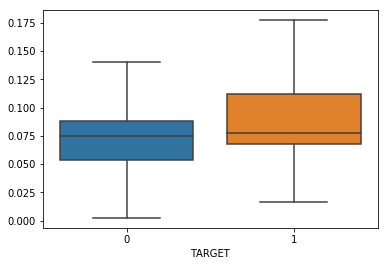

time: 420 ms


In [86]:
sns.boxplot(x=y, y=y_hat, showfliers=False)

#### Principal Components

In [53]:
previous_agg = pd.read_csv(path + "previous_agg.csv")
frame = previous_agg.drop(["SK_ID_CURR", "PREVIOUS_AGG_SYNTHETIC_TARGET"], axis=1)
frame = pd.DataFrame(scale.fit_transform(impute.fit_transform(frame.replace([-np.inf, np.inf], np.nan))), columns=frame.columns)
frame.head()

,MIN_PREV_AMT_ANNUITY_12M,MIN_PREV_AMT_ANNUITY_24M,MIN_PREV_PROP_APPROVED_12M,AVG_SYNTH_TARGET_12M,AVG_PREV_PROP_APPROVED_12M,AVG_PREV_PROP_APPROVED_24M,MAX_PREV_PROP_APPROVED_12M,MAX_PREV_PROP_APPROVED_24M,COUNT_PREV_APP,MIN_PREV_DAYS_TERMINATION,MAX_PREV_DAYS_TERMINATION,AVG_PREV_DAYS_TERMINATION,RANGE_PREV_DAYS_TERMINATION,MIN_PREV_AMT_CREDIT,MAX_PREV_AMT_CREDIT,AVG_PREV_AMT_CREDIT,MIN_PREV_AMT_CREDIT_WEIGHTED,MAX_PREV_AMT_CREDIT_WEIGHTED,AVG_PREV_AMT_CREDIT_WEIGHTED,MIN_PREV_AMT_CREDIT_DIV_ANNUITY,MAX_PREV_AMT_CREDIT_DIV_ANNUITY,AVG_PREV_AMT_CREDIT_DIV_ANNUITY,MIN_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MAX_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,AVG_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MIN_PREV_AMT_ANNUITY,MAX_PREV_AMT_ANNUITY,AVG_PREV_AMT_ANNUITY,MIN_PREV_AMT_ANNUITY_WEIGHTED,MAX_PREV_AMT_ANNUITY_WEIGHTED,AVG_PREV_AMT_ANNUITY_WEIGHTED,MIN_DAYS_DECISION,MAX_DAYS_DECISION,RANGE_DAYS_DECISION,SUM_DAYS_LAST_DUE_NULL,AVG_DAYS_LAST_DUE_NULL,AVG_PREV_REQ_AMOUNT_WEIGHTED,MAX_PREV_REQ_AMOUNT_WEIGHTED,AVG_PREV_REQ_AMOUNT,MAX_PREV_REQ_AMOUNT,AVG_PREV_RATE_DOWNPAYMENT_WEIGHTED,AVG_PREV_PROP_APPROVED_WEIGHTED,MAX_PREV_PROP_APPROVED_WEIGHTED,AVG_PREV_RATE_DOWNPAYMENT,AVG_PREV_PROP_APPROVED,MAX_PREV_PROP_APPROVED,MIN_PREV_PROP_APPROVED,AVG_PREV_INT_RATE,SUM_PREV_URGENT_NEEDS,SUM_PREV_REPAIRS,SUM_PREV_OTHER,SUM_PREV_LIMIT_REJECT,SUM_REFUSED_CONTRACT,SUM_CANC_CONTRACT,SUM_APPR_CONTRACT,SUM_PREV_HC_REJECT,SUM_PREV_INSURE_REQ,COUNT_PREV_WALK_IN,COUNT_PREV_HIGH_YIELD,COUNT_PREV_LOW_YIELD,AVG_SYNTH_TARGET,SUM_SYNTH_TARGET_WEIGHTED,SUM_SYNTH_TARGET,MAX_SYNTH_TARGET,MIN_SYNTH_TARGET,RANGE_SYNTH_TARGET,SUM_DAYS_LAST_DUE_1ST_VERSION_EQ_DAYS_LAST_DUE,SUM_DAYS_FIRST_DRAWING_SENTINEL,SUM_DAYS_FIRST_DRAWING_SENTINEL_WEIGHTED,MAX_DAYS_FIRST_DRAWING_SENTINEL_WEIGHTED,SUM_DAYS_LAST_DUE_LT_FIRST_VERSION,MIN_RATE_INTEREST_PRIMARY_12M,AVG_RATE_INTEREST_PRIVILEGED_12M,SUM_REFUSED_CONTRACT_6M,SUM_PRODUCT_COMBINATION_POS_HOUSE_INTEREST_12M,SUM_PRODUCT_COMBINATION_POS_MOBILE_INTEREST_12M,SUM_NAME_GOODS_CATEGORY_XNA_6M,SUM_NAME_SELLER_INDUSTRY_XNA_6M,SUM_NAME_SELLER_INDUSTRY_CSTR_6M,SUM_NAME_PAYMENT_TYPE_XNA_6M,COUNT_NAME_CLIENT_TYPE_REPEATER_12M,COUNT_NAME_CLIENT_TYPE_NEW_12M,AVG_PREV_AMT_CREDIT_DIV_AMT_ANNUITY_6M,MIN_PREV_AMT_CREDIT_DIV_AMT_ANNUITY_6M,MAX_PREV_AMT_CREDIT_DIV_AMT_ANNUITY_6M,AVG_PREV_AMT_CREDIT_DIV_AMT_GOODS_PRICE_6M,MAX_PREV_AMT_CREDIT_DIV_AMT_GOODS_PRICE_6M,AVG_PREV_AMT_CREDIT_PLUS_AMT_ANNUITY_6M,MIN_PREV_AMT_CREDIT_PLUS_AMT_ANNUITY_6M
0,-0.20337,-0.269348,-0.091275,-0.064120,-0.038181,0.010188,-0.043361,-0.031073,-0.930878,-0.290102,-1.046355,-0.806661,-0.888488,-0.253118,-0.859038,-0.888254,-0.061548,-0.146919,-0.152410,-0.481760,-1.247146,-1.274387,-0.102814,-0.203811,-0.215664,-0.521022,-1.038093,-1.060894,-0.088357,-0.183755,-0.191317,-0.228004,-2.343923,-1.182417,-0.652054,-1.015875,-0.152471,-0.147753,-0.849415,-0.835933,-0.097335,-0.264047,-0.235391,0.274481,-0.598271,-0.830647,0.220864,0.000575,-0.119362,-0.180841,-0.15509,-0.253959,-0.468607,-0.541780,-0.964522,-0.369597,-0.740713,-0.405002,-0.030494,-0.798083,1.111128,-0.313478,-0.880846,-0.087539,1.802039,-0.817701,-1.002924,-0.890906,-0.324769,-0.236958,-0.120713,-0.00144,0.014483,-0.309833,-0.286025,-0.265768,-0.373496,-0.364695,-0.068306,-0.39633,-0.584399,-0.226737,-0.134695,-0.190281,-0.083524,-0.065043,-0.030225,-0.17607,-0.174794
1,-0.20337,-0.283452,-0.091275,-0.064120,-0.038181,-0.471055,-0.043361,-0.601476,-0.930878,-0.273684,-1.037628,-0.792062,-0.888488,1.356782,-0.519619,0.052874,0.188220,-0.133320,-0.095998,2.722014,0.144542,1.363771,0.228852,-0.156504,-0.082367,0.176605,-0.762751,-0.535396,0.014917,-0.168238,-0.147301,1.082426,-0.231896,-1.182417,-0.652054,-1.015875,-0.091135,-0.132774,0.161104,-0.470430,-0.178424,-0.159590,-0.196526,-0.925028,-0.161182,-0.580702,0.522011,0.000575,-0.119362,-0.180841,-0.15509,-0.253959,-0.468607,-0.541780,-0.964522,-0.369597,-0.740713,-0.405002,-0.744408,-0.145070,-0.684578,-0.302593,-0.967610,-0.756779,0.337882,-0.817701,-1.002924,-0.89

time: 40.6 s


In [54]:
previous_agg.shape

(338857, 91)

time: 5.57 ms


In [55]:
frame.shape

(338857, 89)

time: 3.72 ms


In [56]:
num_comp = 7
pca = PCA(n_components=num_comp)
pca.fit(frame)
princomp = pd.DataFrame(np.dot(frame, pca.components_.T), columns=["PREVIOUS_AGG_COMP" + str(i+1) for i in range(num_comp)])
previous_agg = pd.concat([previous_agg, princomp], axis=1)
previous_agg.head()

,SK_ID_CURR,MIN_PREV_AMT_ANNUITY_12M,MIN_PREV_AMT_ANNUITY_24M,MIN_PREV_PROP_APPROVED_12M,AVG_SYNTH_TARGET_12M,AVG_PREV_PROP_APPROVED_12M,AVG_PREV_PROP_APPROVED_24M,MAX_PREV_PROP_APPROVED_12M,MAX_PREV_PROP_APPROVED_24M,COUNT_PREV_APP,MIN_PREV_DAYS_TERMINATION,MAX_PREV_DAYS_TERMINATION,AVG_PREV_DAYS_TERMINATION,RANGE_PREV_DAYS_TERMINATION,MIN_PREV_AMT_CREDIT,MAX_PREV_AMT_CREDIT,AVG_PREV_AMT_CREDIT,MIN_PREV_AMT_CREDIT_WEIGHTED,MAX_PREV_AMT_CREDIT_WEIGHTED,AVG_PREV_AMT_CREDIT_WEIGHTED,MIN_PREV_AMT_CREDIT_DIV_ANNUITY,MAX_PREV_AMT_CREDIT_DIV_ANNUITY,AVG_PREV_AMT_CREDIT_DIV_ANNUITY,MIN_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MAX_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,AVG_PREV_AMT_CREDIT_DIV_ANNUITY_WEIGHTED,MIN_PREV_AMT_ANNUITY,MAX_PREV_AMT_ANNUITY,AVG_PREV_AMT_ANNUITY,MIN_PREV_AMT_ANNUITY_WEIGHTED,MAX_PREV_AMT_ANNUITY_WEIGHTED,AVG_PREV_AMT_ANNUITY_WEIGHTED,MIN_DAYS_DECISION,MAX_DAYS_DECISION,RANGE_DAYS_DECISION,SUM_DAYS_LAST_DUE_NULL,AVG_DAYS_LAST_DUE_NULL,AVG_PREV_REQ_AMOUNT_WEIGHTED,MAX_PREV_REQ_AMOUNT_WEIGHTED,AVG_PREV_REQ_AMOUNT,MAX_PREV_REQ_AMOUNT,AVG_PREV_RATE_DOWNPAYMENT_WEIGHTED,AVG_PREV_PROP_APPROVED_WEIGHTED,MAX_PREV_PROP_APPROVED_WEIGHTED,AVG_PREV_RATE_DOWNPAYMENT,AVG_PREV_PROP_APPROVED,MAX_PREV_PROP_APPROVED,MIN_PREV_PROP_APPROVED,AVG_PREV_INT_RATE,SUM_PREV_URGENT_NEEDS,SUM_PREV_REPAIRS,SUM_PREV_OTHER,SUM_PREV_LIMIT_REJECT,SUM_REFUSED_CONTRACT,SUM_CANC_CONTRACT,SUM_APPR_CONTRACT,SUM_PREV_HC_REJECT,SUM_PREV_INSURE_REQ,COUNT_PREV_WALK_IN,COUNT_PREV_HIGH_YIELD,COUNT_PREV_LOW_YIELD,AVG_SYNTH_TARGET,SUM_SYNTH_TARGET_WEIGHTED,SUM_SYNTH_TARGET,MAX_SYNTH_TARGET,MIN_SYNTH_TARGET,RANGE_SYNTH_TARGET,SUM_DAYS_LAST_DUE_1ST_VERSION_EQ_DAYS_LAST_DUE,SUM_DAYS_FIRST_DRAWING_SENTINEL,SUM_DAYS_FIRST_DRAWING_SENTINEL_WEIGHTED,MAX_DAYS_FIRST_DRAWING_SENTINEL_WEIGHTED,SUM_DAYS_LAST_DUE_LT_FIRST_VERSION,MIN_RATE_INTEREST_PRIMARY_12M,AVG_RATE_INTEREST_PRIVILEGED_12M,SUM_REFUSED_CONTRACT_6M,SUM_PRODUCT_COMBINATION_POS_HOUSE_INTEREST_12M,SUM_PRODUCT_COMBINATION_POS_MOBILE_INTEREST_12M,SUM_NAME_GOODS_CATEGORY_XNA_6M,SUM_NAME_SELLER_INDUSTRY_XNA_6M,SUM_NAME_SELLER_INDUSTRY_CSTR_6M,SUM_NAME_PAYMENT_TYPE_XNA_6M,COUNT_NAME_CLIENT_TYPE_REPEATER_12M,COUNT_NAME_CLIENT_TYPE_NEW_12M,AVG_PREV_AMT_CREDIT_DIV_AMT_ANNUITY_6M,MIN_PREV_AMT_CREDIT_DIV_AMT_ANNUITY_6M,MAX_PREV_AMT_CREDIT_DIV_AMT_ANNUITY_6M,AVG_PREV_AMT_CREDIT_DIV_AMT_GOODS_PRICE_6M,MAX_PREV_AMT_CREDIT_DIV_AMT_GOODS_PRICE_6M,AVG_PREV_AMT_CREDIT_PLUS_AMT_ANNUITY_6M,MIN_PREV_AMT_CREDIT_PLUS_AMT_ANNUITY_6M,PREVIOUS_AGG_SYNTHETIC_TARGET,PREVIOUS_AGG_COMP1,PREVIOUS_AGG_COMP2,PREVIOUS_AGG_COMP3,PREVIOUS_AGG_COMP4,PREVIOUS_AGG_COMP5,PREVIOUS_AGG_COMP6,PREVIOUS_AGG_COMP7
0,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,-1612.0,-1612.0,-1612.000000,0.0,23787.0,23787.0,23787.00,13.670690,13.670690,13.670690,6.020501,6.020501,6.020501,0.003460,0.003460,0.003460,3951.000,3951.000,3951.000,2.270690,2.270690,2.270690,-1740.0,-1740.0,0.0,0.0,0.0,14.273276,14.273276,24835.50,24835.5,0.000060,0.000550,0.000550,0.104326,0.957782,0.957782,0.957782,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.101729,0.000058,0.101729,0.101729,0.101729,0.000000,0.0,1.0,0.000575,0.000575,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100105,-4.431181,0.870323,-0.702195,1.423009,-0.227436,-2.116440,1.437661
1,100002,NaN,9251.775,NaN,NaN,NaN,1.0,NaN,1.0,1.0,-17.0,-17.0,-17.000000,0.0,179055.0,179055.0,179055.00,295.470297,295.470297,295.470297,19.353584,19.353584,19.353584,0.031937,0.031937,0.031937,9251.775,9251.775,9251.775,15.266955,15.266955,15.266955,-606.0,-606.0,0.0,0.0,0.0,295.470297,295.470297,179055.00,179055.0,0.000000,0.001650,0.001650,0.000000,1.000000,1.000000,1.000000,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.071974,0.000119,0.071974,0.071974,0.071974,0.000000,0.0,1.0,0.001650,0.001650,1.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070127,-3.110865,1.646351,2.388491,0.359414,-0.475194,0.397970,0.492820
2,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,-1976

time: 6.35 s


In [57]:
previous_agg.shape

(338857, 98)

time: 5.09 ms
